In [1]:
%load_ext autoreload
%autoreload 2

#Misc
import time, os, sys, pdb, subprocess
from glob import glob
from fnmatch import fnmatch

#Base
import numpy as np
import pandas as pd
import scipy.stats as st

#Save
import json
import scipy.io as sio
import h5py
import io_dict_to_hdf5 as ioh5

#Plot
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
# cmap = usrplt.gradient_cmap(usrplt.color_palette)
sns.set_style("ticks")

#Model
import ssm

#User
import util
import plotting as usrplt


In [22]:
glob(os.path.join(DataDir,'K-12','*_Kappa-{:.0e}.pdf'.format(k)))[0].split('/')

['.',
 'results',
 'sticky-ARHMM_lag-1_K-12_dsf-2_2020-11-14_1841',
 'K-12',
 'AR-matrices_sARHMM_lag-1_K-12_dsf-2_Kappa-1e+08.pdf']

In [19]:
subprocess.run("pwd", shell=True,capture_output=True)


CompletedProcess(args='pwd', returncode=0)

In [ ]:
DataDir = './results/sticky-ARHMM_lag-1_K-12_dsf-2_2020-11-14_1841'

kappas = np.array([1E4,5E4,1E5,5E5,1E6,5E6,1E7,5E7,1E8])
for k in kappas:
    SaveDir = os.path.join(DataDir, 'Kappa-{:.0e}'.format(k))
    if not os.path.isdir(SaveDir):
        os.makedirs(SaveDir) 
        
    files = glob(os.path.join(DataDir,'K-12','*_Kappa-{:.0e}.h5'.format(k)))
    for f in files:
        fname = f.split('/')[-1]
        cmd = 'cp {} {}'.format(f,os.path.join(SaveDir,fname))
        subprocess.run(cmd,shell=True)
        print(cmd)
#         pdb.set_trace()
        

In [2]:
##===== Model Parameters =====##
BaseDir = './results/sticky-ARHMM_lag-2_K-10_dsf-2_2020-11-11_1749/'
# BaseDir = './results/sticky-ARHMM_lag-2_K-10_dsf-1_2020-11-10_1857/'
# BaseDir = './results/standard-ARHMM_lag-1_2020-10-24_1310/'
BaseDir = './results/sticky-ARHMM_lag-1_K-12_dsf-2_2020-11-14_1841'
with open(os.path.join(BaseDir,'ARHMM_hyperparameters.json')) as json_file:
    opt = json.load(json_file)
# opt['downsample_factor'] = 1
opt

{'save': 1,
 'mID': 'all_mice',
 'downsample_factor': 2,
 'model_type': 'ARHMM',
 'transitions': 'sticky',
 'observations': 'autoregressive',
 'inputdriven': 0,
 'kappa_min': 100.0,
 'kappa_max': 10000000.0,
 'AR_lags': 1,
 'MAP_threshold': 0.75,
 'K': 12,
 'kXval': 5,
 'EM_tolerance': 1e-06,
 'EM_iters': 200,
 'max_processes': 5,
 'SaveDirRoot': '/home/dwyrick/projects/jumping_behavior/results/sticky-ARHMM_lag-1_dsf-2_2020-11-14_1841'}

In [3]:
##====== ============ ======##
##====== Read in Data ======##
data_df = pd.read_hdf('./data/jumping_data_102220.h5')
nTrials = len(data_df)

#DLC tracking confidence threshold at which to mask out data
confidence_threshold = 0.8

dsf = opt['downsample_factor']

#Loop over trials and reformat data for ARHMM
data_list = []; mask_list = []
for iTrial in range(nTrials):
    #Get coordinates of Take-Off platform
    xc = np.nanmean(data_df.loc[iTrial]['Side TakeFL x'])
    yc = np.nanmean(data_df.loc[iTrial]['Side TakeFL y'])

    xy_list = []; ll_list = []
    for ii, ptstr in enumerate(['Nose','LEye','LEar']):
        x = data_df.loc[iTrial]['Side {} x'.format(ptstr)]
        y = data_df.loc[iTrial]['Side {} y'.format(ptstr)]
        llhood = data_df.loc[iTrial]['Side {} likelihood'.format(ptstr)]

        #Coordinates relative to take-off platform
        xy_list.append((x-xc,y-yc))

        #Create mask for points that have a confidence lower than the given threshold
        mask = llhood > confidence_threshold
        ll_list.append((mask,mask))

    #Downsample if required
    tmp = np.vstack(xy_list)[:,2:-2].T; tmp2 = tmp if dsf == 1 else tmp[::dsf,:]; data_list.append(tmp2)
    tmp = np.vstack(ll_list)[:,2:-2].T; tmp2 = tmp if dsf == 1 else tmp[::dsf,:]; mask_list.append(tmp2)

#Get number of time points and components per experiment
nT, dObs = data_list[0].shape
nComponents = dObs; opt['dObs'] = dObs

In [77]:

#Plot things for lag=2 kappa runs
# kappas = np.array([5E4,5E5,5E6,5E7,1E8])
# kappas = np.array([1E4,1E5,1E6,1E7])
kappas = np.array([1E4,5E4,1E5,5E5,1E6,5E6,1E7,5E7,1E8])

msd_list = []
su_list = []
for ii, kappa in enumerate(kappas):
    print('\n{}:'.format(kappa),end='\t')
    SaveDir = os.path.join(BaseDir,'Kappa-{:.0e}'.format(kappa))
    fname_sffx = 'sARHMM_lag-{}_K-{:02d}_Kappa-{:.0e}'.format(opt['AR_lags'],opt['K'],kappa)
    
    #Load MAP sequence results
    fpath = glob(os.path.join(SaveDir,'MAP_seqs*.h5'))[0]
    trMAPs, trPosteriors, trMasks, arhmm_params, _ = ioh5.load_MAP_seqs_h5(fpath)
        
    ## Calculate & plot state duration and state usage 
    state_duration_list, state_startend_list, mean_state_durations, state_usage = util.get_state_durations(trMAPs, trMasks, opt['K'])
    
    msd_list.append(mean_state_durations)
    su_list.append(state_usage)

    



10000.0:	

/home/dwyrick/projects/jumping_behavior/io_dict_to_hdf5.py:66: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ans[key] = item.value



50000.0:	
100000.0:	
500000.0:	
1000000.0:	
5000000.0:	
10000000.0:	
50000000.0:	
100000000.0:	

Text(0, 0.5, 'Median State Duration (ms)')

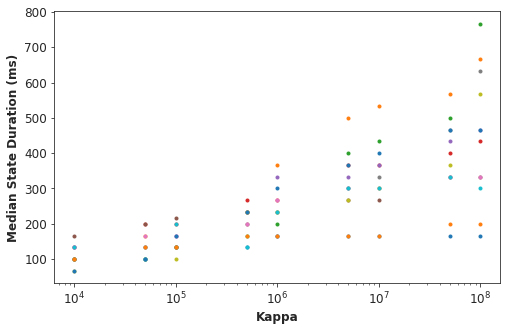

In [78]:
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(kappas,np.array(msd_list)[:,:-1]*dsf*1E3/60,'.')
plt.xscale('log')
plt.xlabel('Kappa'); plt.ylabel('Median State Duration (ms)')

Text(0, 0.5, 'Mean State Duration (ms)')

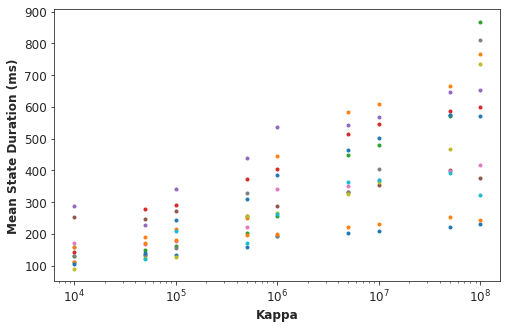

In [76]:
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(kappas,np.array(msd_list)[:,:-1]*dsf*1E3/60,'.')
plt.xscale('log')
plt.xlabel('Kappa'); plt.ylabel('Mean State Duration (ms)')

In [71]:
msd_sorted_list = []
for ii, kappa in enumerate(kappas):
    su = su_list[ii]
    msd = np.array(msd_list[ii])
    perm = np.argsort(su)[::-1]
    state_usage = np.sort(su)[::-1]
    msd_sorted_list.append(msd[perm])

In [66]:
K = opt['K']
Ks = np.arange(K+1)
cpalette = usrplt.color_palette[:K+1]
pdfdoc = PdfPages(os.path.join(BaseDir,'State_usage_across-kappas.pdf'))
for kappa,su in zip(kappas,su_list):
    fig,ax = plt.subplots(figsize=(8,4))
    plt.suptitle('State Usage for Kappa={:.0e}'.format(kappa))

    perm = np.argsort(su)[::-1]
    state_usage = np.sort(su)[::-1]
    cpalette = [usrplt.color_palette[p] for p in perm]
    sns.barplot(Ks,state_usage*100,palette=cpalette,ax=ax)
    ax.hlines(100/K,*ax.get_xlim(),ls='--',color='k',label='Equal Usage K={}'.format(K))
    ax.set_xlabel('State')
    ax.set_ylabel('Usage',fontsize=12)

    tmp = [str(i) for i in np.arange(K)]
    tmp.append('NaN')
    xlabels = [tmp[p] for p in perm]
    ax.set_xticklabels(xlabels)
    ax.legend()
    
#     plt.show()
#     pdb.set_trace()
    
    SaveDir = os.path.join(BaseDir,'Kappa-{:.0e}'.format(kappa))
    fname_sffx = 'sARHMM_lag-{}_K-{:02d}_Kappa-{:.0e}'.format(opt['AR_lags'],opt['K'],kappa)
    plt.savefig(os.path.join(SaveDir,'state_usage_{}.png'.format(fname_sffx)))

    pdfdoc.savefig(fig)
    plt.close(fig)
pdfdoc.close()

In [130]:
arhmm_params.keys()

dict_keys(['init_state_distn', 'observations', 'transitions'])

In [142]:
arhmm_params['transitions'].keys()

dict_keys(['log_Ps'])

In [141]:
arhmm_params['observations']['bs'].shape

(16, 6)

In [5]:
obs_dim = 6

In [ ]:
tTest

In [ ]:
    #Let's calculate the BIC as well for this
    BIC_heldout = num_parameters*np.log(nTest) - 2*hmm.log_probability(test_data)

In [20]:
##===== Let's look at the cross-validation results over K for various sticky ARHMMs ======##
kappas = np.array([1E4,5E5,1E6,5E6,1E7])
Ks = np.arange(6,17,1)

ll_heldout = np.zeros((len(kappas),len(Ks),3),dtype=np.float64)
BIC_heldout = np.zeros((len(kappas),len(Ks),3),dtype=np.float64)

for ii, kappa in enumerate(kappas):
    print('\n{:.0e}: '.format(kappa))
    BaseDir = glob('./results/sticky-ARHMM_lag-1_dsf-2_kappa-{:.0e}_*'.format(kappa))[0]
    with open(os.path.join(BaseDir,'ARHMM_hyperparameters.json')) as json_file:
        opt = json.load(json_file)
        
    for jj, K in enumerate(Ks):
        # Initial state distribution + A matrices + B matrices + covariance + transition probability matrix
        num_parameters = K + K*obs_dim*obs_dim + K*obs_dim + K*obs_dim*obs_dim + K*K
        print('{}, '.format(K),end='')
        KDir = os.path.join(BaseDir,'K-{:02d}'.format(K))
        
        #Get full model cross-validation
        fpath = glob(os.path.join(KDir,'fit_parameters*.h5'))[0]
        data = ioh5.load(fpath)
        tTest = data['tTest']; tTrain = data['tTrain']
        ll = data['ll_heldout_perstep']*tTest
        
        #Calculate number of timepoints 
        nTest = tTest*obs_dim; nTrain = tTrain*obs_dim
        ll_heldout[ii,jj,-1] = ll/nTest

        #Calculate BIC
        BIC_heldout[ii,jj,-1] = num_parameters*np.log(nTest) - 2*ll
        
        kfold_dirs = sorted(glob(os.path.join(KDir,'kFold_*')))
        for kk,kfold in enumerate(kfold_dirs):
            fpath = glob(os.path.join(kfold,'fit_parameters*.h5'))[0]
            data = ioh5.load(fpath)
            
            tTest = data['tTest']; tTrain = data['tTrain']
            ll = data['ll_heldout_perstep']*tTest
            
            #Calculate number of timepoints 
            nTest = tTest*obs_dim; nTrain = tTrain*obs_dim
        
            
            ll_heldout[ii,jj,kk] = ll/nTest
            #Calculate BIC
            BIC_heldout[ii,jj,kk] = num_parameters*np.log(nTest) - 2*ll



1e+04: 
6, 

/home/dwyrick/projects/jumping_behavior/io_dict_to_hdf5.py:66: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ans[key] = item.value


7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 
5e+05: 
6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 
1e+06: 
6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 
5e+06: 
6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 
1e+07: 
6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 

In [17]:
num_parameters*np.log(nTest)


22096.160618087855

In [19]:
BIC_heldout[0]

array([[       0.        ,        0.        , 13520631.91617162],
       [       0.        ,        0.        , 13470095.20017184],
       [       0.        ,        0.        , 13363166.82781609],
       [       0.        ,        0.        , 13366197.47693636],
       [       0.        ,        0.        , 13273981.7392666 ],
       [       0.        ,        0.        , 13288961.75907168],
       [       0.        ,        0.        , 13223514.2486402 ],
       [       0.        ,        0.        , 13209490.24561642],
       [       0.        ,        0.        , 13223790.717452  ],
       [       0.        ,        0.        , 13189806.34070694],
       [       0.        ,        0.        , 13160738.42051077]])

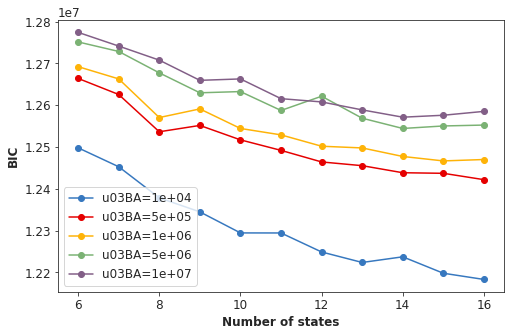

In [23]:
fig, ax = plt.subplots(figsize=(8,5))
for ii, kappa in enumerate(kappas):

    ax.plot(Ks,np.mean(BIC_heldout[ii,:,:-1],axis=-1),'o-',color=usrplt.cc[ii],label='u03BA={:.0e}'.format(kappa))
ax.set_xlabel('Number of states'); ax.set_ylabel('BIC')
ax.legend()
plt.savefig('./plots/BIC.png')

In [ ]:
##===== Let's look at the cross-validation results over K for various sticky ARHMMs ======##
kappas = np.array([1E4,5E5,1E6,5E6,1E7])
Ks = np.arange(6,17,1)

ll_heldout = np.zeros((len(kappas),len(Ks),3),dtype=np.float64)
BIC_heldout = np.zeros((len(kappas),len(Ks),3),dtype=np.float64)

for ii, kappa in enumerate(kappas):
    print('\n{:.0e}: '.format(kappa))
    BaseDir = glob('./results/standard-ARHMM_lag-1_dsf-2_kappa-{:.0e}_*'.format(kappa))[0]
    with open(os.path.join(BaseDir,'ARHMM_hyperparameters.json')) as json_file:
        opt = json.load(json_file)
        
    for jj, K in enumerate(Ks):
        # Initial state distribution + A matrices + B matrices + covariance + transition probability matrix
        num_parameters = K + K*obs_dim*obs_dim + K*obs_dim + K*obs_dim*obs_dim + K*K
        print('{}, '.format(K),end='')
        KDir = os.path.join(BaseDir,'K-{:02d}'.format(K))
        
        #Get full model cross-validation
        fpath = glob(os.path.join(KDir,'fit_parameters*.h5'))[0]
        data = ioh5.load(fpath)
        tTest = data['tTest']; tTrain = data['tTrain']
        ll = data['ll_heldout_perstep']*tTest
        
        #Calculate number of timepoints 
        nTest = tTest*obs_dim; nTrain = tTrain*obs_dim
        ll_heldout[ii,jj,-1] = ll/nTest

        #Calculate BIC
        BIC_heldout[ii,jj,-1] = num_parameters*np.log(nTest) - 2*ll
        
        kfold_dirs = sorted(glob(os.path.join(KDir,'kFold_*')))
        for kk,kfold in enumerate(kfold_dirs):
            fpath = glob(os.path.join(kfold,'fit_parameters*.h5'))[0]
            data = ioh5.load(fpath)
            
            tTest = data['tTest']; tTrain = data['tTrain']
            ll = data['ll_heldout_perstep']*tTest
            
            #Calculate number of timepoints 
            nTest = tTest*obs_dim; nTrain = tTrain*obs_dim
        
            
            ll_heldout[ii,jj,kk] = ll/nTest
            #Calculate BIC
            BIC_heldout[ii,jj,kk] = num_parameters*np.log(nTest) - 2*ll


In [84]:
    
    #Load MAP sequence results
    fpath = glob(os.path.join(SaveDir,'MAP_seqs*.h5'))[0]
    trMAPs, trPosteriors, trMasks, arhmm_params, _ = ioh5.load_MAP_seqs_h5(fpath)
        
    ## Calculate & plot state duration and state usage 
    state_duration_list, state_startend_list, mean_state_durations, state_usage = util.get_state_durations(trMAPs, trMasks, opt['K'])
    
    msd_list.append(mean_state_durations)
    su_list.append(state_usage)


(11,)

In [123]:
##===== Let's look at the cross-validation results over K for various sticky ARHMMs ======##
kappas = np.array([1E4,5E5,1E6,5E6,1E7])
Ks = np.arange(6,17,1)

msd_array1 = np.zeros((len(kappas),len(Ks),16)); msd_array1[:] = np.nan
su_array1 = np.zeros((len(kappas),len(Ks),16)); su_array1[:] = np.nan
for ii, kappa in enumerate(kappas):
    print('\n{:.0e}: '.format(kappa))
    BaseDir = glob('./results/sticky-ARHMM_lag-1_dsf-2_kappa-{:.0e}_*'.format(kappa))[0]
    
    msd_list = []; su_list = []
    for jj, K in enumerate(Ks):
        print('{}, '.format(K),end='')
        KDir = os.path.join(BaseDir,'K-{:02d}'.format(K))
        
        #Load MAP sequence results
        fpath = glob(os.path.join(KDir,'MAP_seqs*.h5'))[0]
        trMAPs, trPosteriors, trMasks, arhmm_params, opt = ioh5.load_MAP_seqs_h5(fpath)

        ## Calculate & plot state duration and state usage 
        state_duration_list, state_startend_list, mean_state_durations, state_usage = util.get_state_durations(trMAPs, trMasks, opt['K'])

        perm = np.argsort(mean_state_durations[:-1])[::-1]
        msd_array1[ii,jj,:K] = np.sort(mean_state_durations[:-1])[::-1]
        
        tmp = state_usage[:-1]
        su_array1[ii,jj,:K] = tmp[perm]
#         pdb.set_trace()


1e+04: 
6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 
5e+05: 
6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 
1e+06: 
6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 
5e+06: 
6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 
1e+07: 
6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 

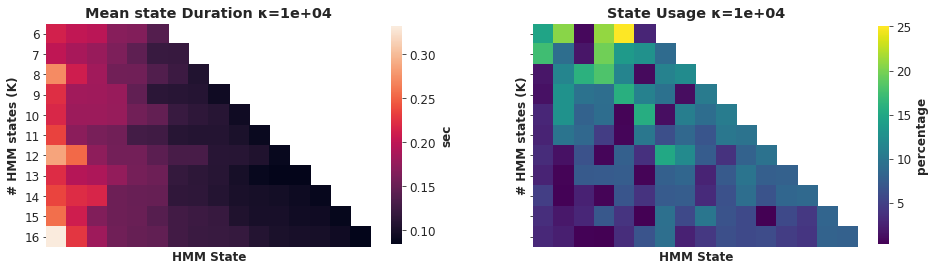

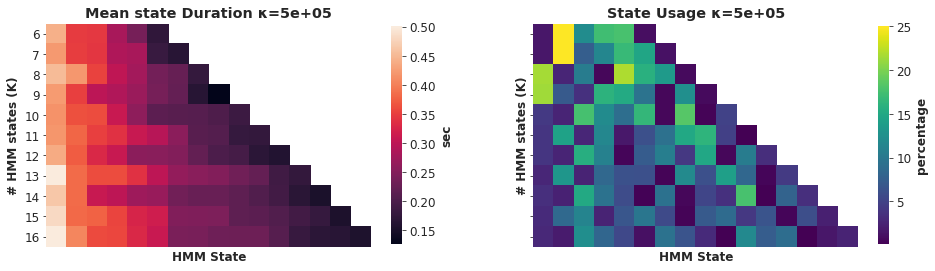

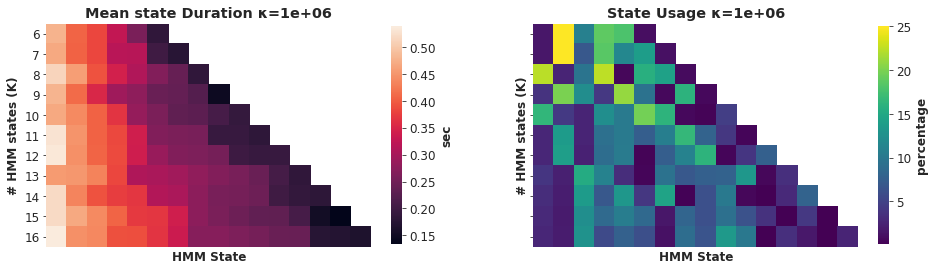

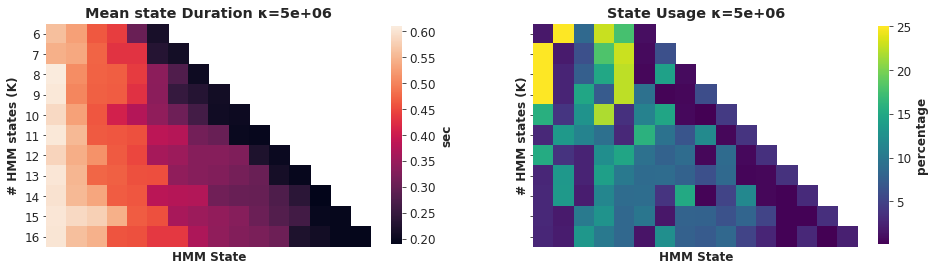

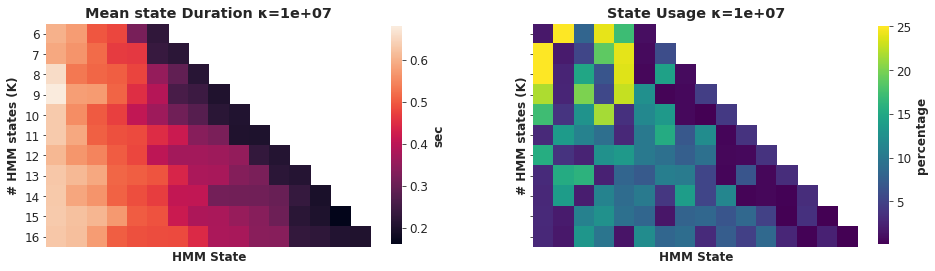

In [125]:

for ii, kappa in enumerate(kappas):
    fig, axes = plt.subplots(1,2,figsize=(16,8),sharey=True)
    ax = axes[0]
    ax.set_title('Mean state Duration \u03BA={:.0e}'.format(kappa))
    sns.heatmap(msd_array1[ii]*dsf/60,square=True,ax=ax,cbar_kws={'shrink': 0.5,'label': 'sec'})
    
    ax = axes[1]
    ax.set_title('State Usage \u03BA={:.0e}'.format(kappa))
    sns.heatmap(su_array1[ii]*100,square=True,ax=ax,cmap='viridis',vmax=25,cbar_kws={'shrink': 0.5,'label': 'percentage'})
    
    for ax in axes:
        ax.set_yticklabels(Ks,rotation=0)
        ax.set_xticks([])
        ax.set_xlabel('HMM State'); ax.set_ylabel('# HMM states (K)')
    

In [ ]:
msd_array = np.zeros((len(Ks),len(kappas),16)); msd_array[:] = np.nan
su_array = np.zeros((len(Ks),len(kappas),16)); su_array[:] = np.nan
for jj, K in enumerate(Ks): 
    print(K)
    for ii, kappa in enumerate(kappas):
        BaseDir = glob('./results/sticky-ARHMM_lag-1_dsf-2_kappa-{:.0e}_*'.format(kappa))[0]
    
        KDir = os.path.join(BaseDir,'K-{:02d}'.format(K))
        
        #Load MAP sequence results
        fpath = glob(os.path.join(KDir,'MAP_seqs*.h5'))[0]
        trMAPs, trPosteriors, trMasks, arhmm_params, opt = ioh5.load_MAP_seqs_h5(fpath)

        ## Calculate & plot state duration and state usage 
        state_duration_list, state_startend_list, mean_state_durations, state_usage = util.get_state_durations(trMAPs, trMasks, K)
        msd_array[jj,ii,:K] = np.sort(mean_state_durations[:-1])[::-1]
        
        perm = np.argsort(mean_state_durations[:-1])[::-1]        
        tmp = state_usage[:-1]
        su_array[jj,ii,:K] = tmp[perm]
#         pdb.set_trace()
        
        

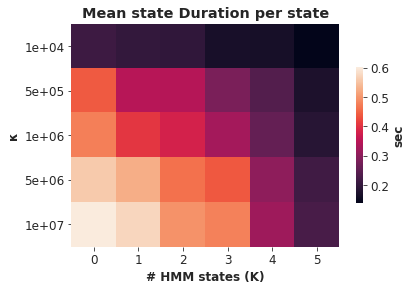

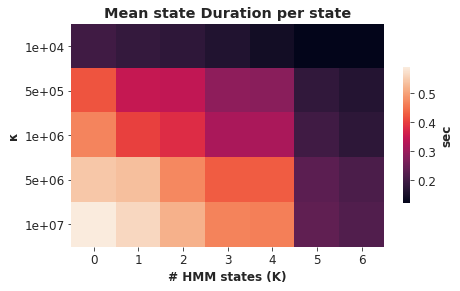

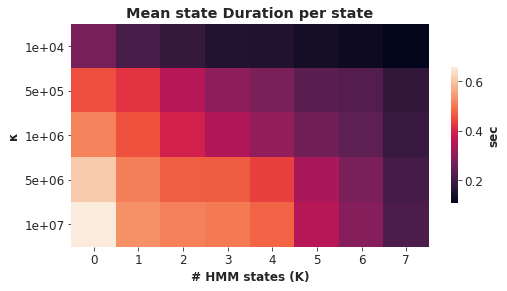

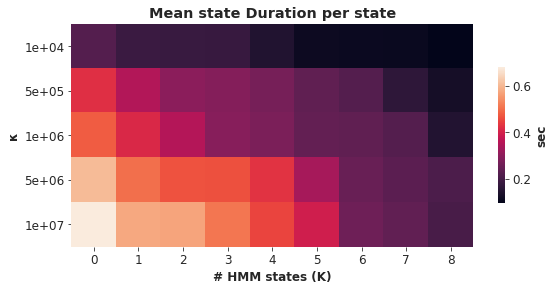

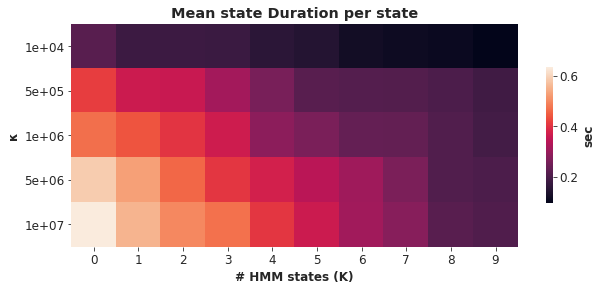

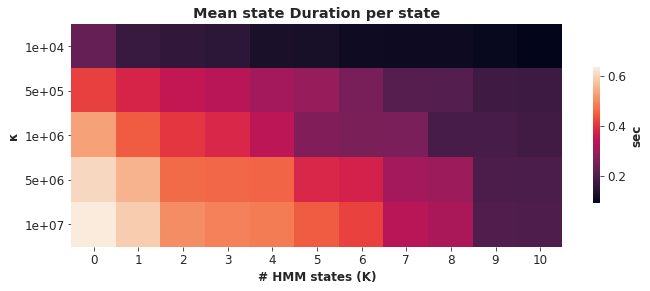

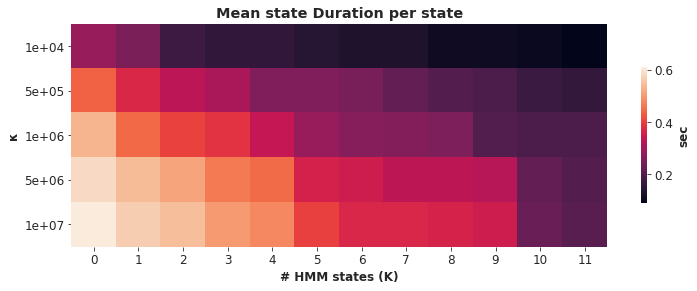

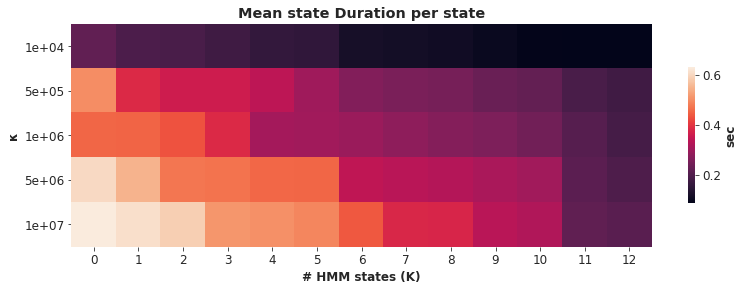

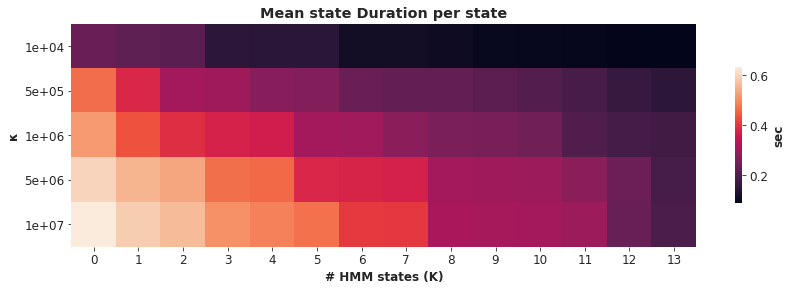

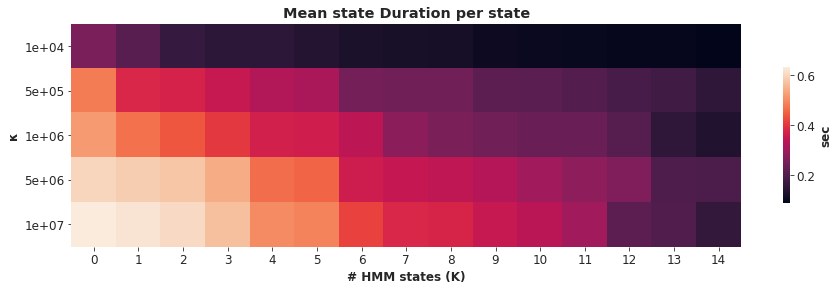

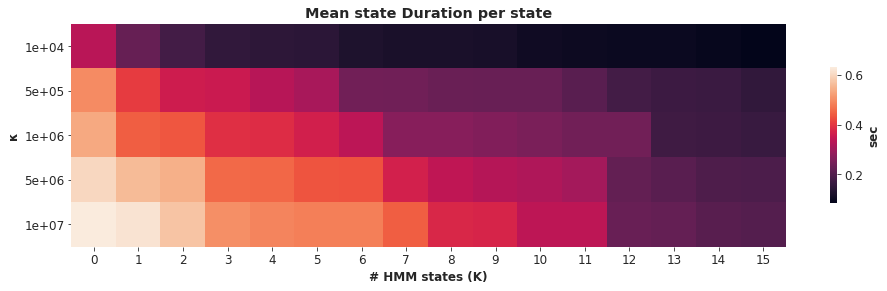

In [115]:

for jj, K in enumerate(Ks):
    fig, ax = plt.subplots(figsize=(K,5))
    ax.set_title('Mean state Duration, K = {}'.format(K))
    sns.heatmap(msd_array[jj,:,:K]*dsf/60,square=True,ax=ax,cbar_kws={'shrink': 0.5,'label': 'sec'})
    ax.set_yticklabels(ticklabels,rotation=0)
    ax.set_ylabel('\u03BA'); ax.set_xlabel('HMM states')
    

In [109]:
ticklabels = ['{:.0e}'.format(kappa) for kappa in kappas]
ticklabels

['1e+04', '5e+05', '1e+06', '5e+06', '1e+07']

In [99]:
len(Ks)

11